# Setup

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import itertools as it

import helpers_07

%matplotlib inline

D:\Anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Transfer Learning

Our goal this week is to apply a *previously trained network* (that was trained on the ILSVRC dataset), modify it slightly, and with only minimal retraining on a new dataset (called HamsterHare), use it to predict on the new task.  Let's go.

# A Different Dataset

As per usual, we've hidden the complexity of grabbing the data.  Because the dataset is a bit bigger, for now, we only return paths to files (and not full images as a NumPy array).  We'll deal with that more in a bit.

In [2]:
helpers_07.download_hh("data/hh")
# note:  label=1 means hare; label=0 means hamster


File hamsterhare.tar.gz already present.
Extracting data for data/hh\hamsterhare.


In [4]:
readable_hh_labels = {1:"hare", 0:"hamster"}
(train_files, train_labels, 
 test_files, test_labels) = helpers_07.train_test_split_hh_filenames(test_pct=.3)

print("\n".join(str(t) for t in train_files[:5]))
print("\n".join(str(t) for t in train_labels[:5]))

data/hamsterhare\hare\n02326432_30081.JPEG
data/hamsterhare\hamster\n02342885_4368.JPEG
data/hamsterhare\hare\n02326432_38335.JPEG
data/hamsterhare\hamster\n02342885_5441.JPEG
data/hamsterhare\hamster\n02342885_10037.JPEG
1
0
1
0
0


Let's see what we're dealing with:

<class 'numpy.ndarray'>


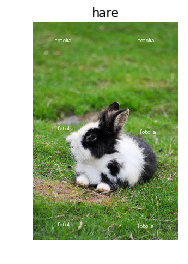

In [20]:
from scipy.misc import imread
img = imread(train_files[0], mode="RGB")[:,:,:3]
plt.imshow(img)
plt.title(readable_hh_labels[train_labels[0]])
plt.axis('off');
print(type(img))

# (Re-)Loading a Model and Accessing Named Model Elements

##### Named Elements

In a few minutes, we are going to reload the AlexNet we built last week.  When we do so, we will have  agrat network, but we will have no variables referencing the Tensors and Operations inside of it.  We need to deal with that, so at minimum we can feed it data.  We'll even go beyond that:  we'll add Operations to the network so we can retrain portions of it.

To get started, let's look at a simpler example.

In [6]:
test_graph = tf.Graph()
with test_graph.as_default():
    a = tf.constant(3,   name="constant_a")
    b = tf.constant(4,   name="constant_b")
    c = tf.multiply(a,b, name="mul_for_c")
print(a)
print(b)
print(c)

Tensor("constant_a:0", shape=(), dtype=int32)
Tensor("constant_b:0", shape=(), dtype=int32)
Tensor("mul_for_c:0", shape=(), dtype=int32)


We can access operations.  A few points:
  * ops are the "nodes" in the graph 
  * they are operations that perform computation
  * op name is same as we passed to name=

In [7]:
print("Getting an Operation")
print(test_graph.get_operation_by_name('mul_for_c'))

Getting an Operation
name: "mul_for_c"
op: "Mul"
input: "constant_a"
input: "constant_b"
attr {
  key: "T"
  value {
    type: DT_INT32
  }
}



And we can access tensors.  A few points:
  * tensors are the data or edges in the Graph
  * they often are the result of an Operation
  * tensor name is the `op:<number>` 
  * many ops have only one output (the data we want), so the number is often 0
  * some ops have multiple outputs, to the numbers go 0,1,2, for diff output tensors

In [8]:
print("Getting a Tensor:")
new_c_ref = test_graph.get_tensor_by_name('mul_for_c:0')
print(c)
print(new_c_ref)
print(c is new_c_ref) # aka, refer to -same- object

Getting a Tensor:
Tensor("mul_for_c:0", shape=(), dtype=int32)
Tensor("mul_for_c:0", shape=(), dtype=int32)
True


# Loading a Graph

Now, let's bring back in the AlexNet we (possibly struggled) to create last week.

In [9]:
# create a placeholder graph to "rehydrate" our freeze-dried AlexNet
old_alex_graph = tf.Graph()
with old_alex_graph.as_default():
    # importing the graph will populate new_alex_graph
    saver = tf.train.import_meta_graph("../Intel-TF101-Class6/saved_models/alexnet.meta")

And we can use some `get_*_by_name` methods to extract out tensors and operations.  Note, we have to know these ahead of time (but, see below!).

In [10]:
# note the form is scope/name= ; for output tensor, we can tack on :0
print(old_alex_graph.get_tensor_by_name('inputs/images:0'), "\n",
      old_alex_graph.get_operation_by_name('inputs/images'), sep="\n")

Tensor("inputs/images:0", shape=(?, ?, ?, 3), dtype=float32)


name: "inputs/images"
op: "Placeholder"
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: -1
      }
      dim {
        size: -1
      }
      dim {
        size: -1
      }
      dim {
        size: 3
      }
    }
  }
}



Now, we have sort of an idealized scenario: we made the graph last week.  So, we know (or we could go back to our old code an lookup) the names of the tensors and operations.  But, what if (1) someone else gave us the graph, (2) we lost our old code, (3) we needed to programmatically get the names of tensors/operations.  What would we do?  Fortunately, this is a solved problem.  We use `get_operations` as in `old_alex_graph.get_operations`.

In [11]:
print("\n".join(str(op.name) for op in old_alex_graph.get_operations()[:20]))

inputs/images
rescale/resize_images/size
rescale/resize_images/ResizeBilinear
alexnet/conv_1/Const
alexnet/conv_1/weight
alexnet/conv_1/weight/Assign
alexnet/conv_1/weight/read
alexnet/conv_1/Const_1
alexnet/conv_1/bias
alexnet/conv_1/bias/Assign
alexnet/conv_1/bias/read
alexnet/conv_1/conv
alexnet/conv_1/BiasAdd
alexnet/conv_1/Relu
alexnet/LRN
alexnet/pool_1/MaxPool
alexnet/conv_2/kernel/initial_value
alexnet/conv_2/kernel
alexnet/conv_2/kernel/Assign
alexnet/conv_2/kernel/read


The way we'll actually use this is to grab the specific tensors we need to work with in our new/transfered use of our AlexNet.  Namely, we need the inputs and we need whatever "end point" we are going to cut off the old AlexNet and move to our new AlexNet.  We're just going to cut out the last layer (`fc8` from last time).  So, we'll pipe `fc7` somewhere else.  More to come on that shortly.

In [12]:
# get references (Python variables) that refer 
# to the named elements we need to access
inputs = old_alex_graph.get_tensor_by_name('inputs/images:0')
fc7    = old_alex_graph.get_tensor_by_name("alexnet/fully_connected_1/fc7:0")

## Exercise

See if you can pickout the operations in the `fully_connected` name scope from the old graph.

### Solution

In [13]:
fc6 = old_alex_graph.get_tensor_by_name("alexnet/fully_connected/fc6:0")

## A Retraining Model

Since our original AlexNet model didn't have any training component (we populated its weights directly from NumPy arrays), we have some work to do, if we want to add training capabilities.  Here's a template from our older trainable models:

## Exercise

Look inside the following code and try to build up a model that resuses as much as possible from the prior model.  Here's was out outline of steps from the slides:

  1. Get handle to output from second-to-last layer
  2. Create a new fully connected layer
    * number of neurons equal to the number of output classes)
  3. Create new softmax cross-entropy loss
  4. Create a training op to minimize the new loss
    * Set var_list parameter to be just the new layer variables
  5. Train with new data!

In [14]:
class TransferedAlexNet:
    def __init__(s, init_graph):
        with init_graph.as_default():
            #
            # The original AlexNet from last week didn't have:
            #      labels, loss, training
            # Also, it's prediction was structured for 1000 output classes
            # 
            # Since we passed in init_graph above, we are working *with* that
            # old AlexNet.  But you can add to it.  For example: here we are *adding*
            # a labels placeholder to the original model:
            with tf.name_scope('inputs'):
                s.labels = tf.placeholder(tf.int32, shape=[None], name='labels')

            #
            # revisit one of your older models, and add in the remaining pieces:
            # learning_rate, loss, global_step, training, a new prediction system, etc.
            # 
            # you'll also need a new final layer to replace the fc8 layer from last time
            # you can use helper_07.fully_connected_xavier_relu_layer
            # to replace it ...
            #
            
            #
            # FILL ME IN
            # 

            init = tf.global_variables_initializer()
        s.session = tf.Session(graph=init_graph)
        s.session.run(init)

    def fit(s, train_dict):
        tr_loss, step, tr_acc, _ = s.session.run([s.loss, s.inc_step, s.pred_accuracy, s.train], 
                                                 feed_dict=train_dict)
        return tr_loss, step, tr_acc
    
    def predict(s, test_dict):
        ct_correct, preds = s.session.run([s.pred_correct, s.prediction], 
                                          feed_dict=test_dict)
        return ct_correct, preds    

### Solution

The following code adds one nice twist.  If you look at lines 31 and 37 (use Control-m followed by l - little 'ell' in the cell to get line numbers), you'll see that we setup a way to only optimize on the selected variables:  in this case, the variables from our new end layer.  This saves a ton of time (fewer parameters to work with) -and- it prevents us from losing the work done in the prior (very long/large) training steps (i.e., the work done before we even got our old AlexNet weights).

In [23]:
class TransferedAlexNet:
    def __init__(s, init_graph, num_tgt_classes):
        with init_graph.as_default():
            with tf.name_scope('inputs'):
                # have input placeholder from original graph
                s.labels = tf.placeholder(tf.int32, shape=[None], name='labels')

            with tf.name_scope('hyperparams'):
                s.learning_rate = tf.placeholder(tf.float32, name='learning_rate')                
            
            s.one_hot_labels = tf.one_hot(s.labels, 2) # , dtype=tf.float32) 
            
            #
            # we're going to rewire the outputs from the old fc7 to our new layer
            #
            orig_fc7    = init_graph.get_tensor_by_name("alexnet/fully_connected_1/fc7:0")
            with tf.name_scope('new_top_layer'):
                # the old fc8 (which we are replacing) had 1000 nodes for 1000 classes
                s.logits = helpers_07.fully_connected_xavier_relu_layer(orig_fc7, num_tgt_classes) 
            
            with tf.name_scope('loss'):
                smce = tf.nn.softmax_cross_entropy_with_logits_v2
                s.loss = tf.reduce_mean(smce(logits=s.logits, labels=s.one_hot_labels),
                                             name="loss")

            with tf.name_scope('global_step'):
                global_step = tf.Variable(0, trainable=False, name='global_step')
                s.inc_step = tf.assign_add(global_step, 1, name='inc_step')

            # use to_train_vars = None to train on all trainable (including those from original)
            to_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "new_top_layer")
            
            with tf.name_scope('train'):
                decayed_rate = tf.train.exponential_decay(s.learning_rate, global_step,
                                                          600, 0.998, True)
                momopt = tf.train.MomentumOptimizer
                s.train = momopt(decayed_rate, 0.9).minimize(s.loss, var_list=to_train_vars)
            
            # there is a prediction namescope in the original model
            # note, that the variable assignments here are attributes of this class
            # and refer to distinct operations compared to the original model
            with tf.name_scope('new_prediction'):
                s.softmax    = tf.nn.softmax(s.logits, name="softmax")
                s.prediction = tf.cast(tf.argmax(s.softmax, 1), tf.int32)
                
                s.pred_correct  = tf.equal(s.labels, s.prediction)
                s.pred_accuracy = tf.reduce_mean(tf.cast(s.pred_correct, tf.float32))    
            
            init = tf.global_variables_initializer()
        s.session = tf.Session(graph=init_graph)
        s.session.run(init)

    def fit(s, train_dict):
        tr_loss, step, tr_acc, _ = s.session.run([s.loss, s.inc_step, s.pred_accuracy, s.train], 
                                                 feed_dict=train_dict)
        return tr_loss, step, tr_acc
    
    def predict(s, test_dict):
        ct_correct, preds = s.session.run([s.pred_correct, s.prediction], 
                                          feed_dict=test_dict)
        return ct_correct, preds    

# Retraining

Now, let's put this all together and retrain with some new data.  I'm going to show a few options that demonstrate different techniques you might need.  One issue we pushed under the hood, was that of the input shape. In TensorFlow, single batches of images must all be the same size.  Even if the AlexNet we built can rescale images to 227 by 227, the inputs all need to be of one, common size.  Even worse, our Hamster Hare images are all varying sizes.   To show off an alternative use of TensorFlow, here is a set of helpers to rescale images (one image at a time).

In [24]:
class TF_ReadAndScale:
    'rescale images to a common size'
    def __init__(self, img_size=[227, 227]):
        self.img_size = img_size
        ras_graph = tf.Graph()
        with ras_graph.as_default():
            self.img_path = tf.placeholder(tf.string)
            raw_data  = tf.read_file(self.img_path)
            jpg_image = tf.image.decode_jpeg(raw_data, channels=3)
            self.scaled_img = tf.image.resize_images(jpg_image, img_size)
        self.session = tf.Session(graph=ras_graph)
        
    def scale(self, img_path):
        return self.session.run(self.scaled_img, feed_dict={self.img_path:img_path})

def image_files_into_array(img_file_lst, dtype=np.uint8, limit=None):
    'take a list of filenames; return an array of images'
    scaler = TF_ReadAndScale()

    num_images = len(img_file_lst)
    img_array_shape = [num_images] + scaler.img_size + [3]
    img_array = np.empty(img_array_shape, dtype=dtype)
    
    for tf, img_home in it.islice(zip(img_file_lst, img_array), limit):
        img_home[:] = scaler.scale(tf)
    return img_array

With that out of the way, let's build our model and get set to feed it new data.

In [25]:
# danger, rerunning will modify a modified model
# b/c the reruns share the old_alex_graph
# and it is updating through the reference
new_alex = TransferedAlexNet(old_alex_graph, num_tgt_classes=2) 
inputs   = old_alex_graph.get_tensor_by_name('inputs/images:0')

We're going to save ourselves a lot of processing time (at the cost of some memory usage) but rescaling all of the images before we pass them for training.  See below for an alternative.

In [26]:
# you can set a limit here to either use all the data (limit = None)
# or, set to a small integer if you want to debug/time test (not for production)
limit = None # use all of a batch   
# limit = 10     # use just 10 images per batch (completely ignore remainder)
batch_size = 32  # you can scale this up, if you want more images through your net at once

# way above, we did:
# (train_files, train_labels, 
#  test_files, test_labels) = helpers_07.train_test_split_hh_filenames(test_pct=.3)
# this load all of the images into memory; could be a problem on some machines
img_array = image_files_into_array(train_files, dtype=np.float32)
lbl_array = np.array(train_labels)

for epoch in range(5):
    start = time.time()
    batcher = helpers_07.array_batches(img_array, lbl_array, batch_size)
    for image_batch, label_batch in it.islice(batcher, limit):
        train_dict = {inputs : image_batch, 
                      new_alex.labels : label_batch, 
                      new_alex.learning_rate : 0.05}
        tr_loss, step, tr_acc = new_alex.fit(train_dict)
    end = time.time()
    info_update = "Epoch: {:2d} Step: {:5d} Loss: {:8.2f} Acc: {:5.2f} Time: {:5.2f}"
    print(info_update.format(epoch, step, tr_loss, tr_acc, (end - start) / 60.0))

Epoch:  0 Step:    56 Loss:     0.37 Acc:  1.00 Time:  0.73
Epoch:  1 Step:   112 Loss:     0.37 Acc:  1.00 Time:  0.52
Epoch:  2 Step:   168 Loss:     0.30 Acc:  0.97 Time:  0.51
Epoch:  3 Step:   224 Loss:     0.41 Acc:  0.97 Time:  0.51
Epoch:  4 Step:   280 Loss:     0.39 Acc:  0.91 Time:  0.51


The following is an alternative that shows off what you might have to do if you have large data and/or small physical memory size.  Instead of loading all the images into memory at once, we simply load them "on demand" as needed by the batches.  Note, the specific loop below also means that we rescale the images every time they are opened.  We could rescale and save and then reopen the saved version, if we wanted.

In [27]:
def do_it():
    scaler = TF_ReadAndScale()
    for epoch in range(5):
        start = time.time()
        batcher = helpers_07.list_batches(train_files, train_labels, 32)
        for file_batch, label_batch in it.islice(batcher, 10):
            image_batch = [scaler.scale(a_file) for a_file in file_batch]
            train_dict = {inputs : image_batch, 
                          new_alex.labels : label_batch, 
                          new_alex.learning_rate : 0.05}
            tr_loss, step, tr_acc = new_alex.fit(train_dict)
        end = time.time()
        info_update = "Epoch: {:2d} Step: {:5d} Loss: {:8.2f} Acc: {:5.2f} Time: {:5.2f}"
        print(info_update.format(epoch, step, tr_loss, tr_acc, (end - start) / 60.0))
# do_it() # disabled

You may want to run this once to see the difference in running times compared to the above "scale them all once" method.

# Evaluation

## Exercise

Using the `.predict` method we gave `TransferedAlexNet`, write some code to evaluate it on a test set.  Remember, we need to scale the test images before they are fed to our model.  Here's a template (that needs several modification to be used) from the Week 04 notebook:

In [30]:
total_correct = 0
test_limit=None
test_img_array = image_files_into_array(test_files, dtype=np.float32)
test_lbl_array = np.array(test_labels)
batcher = helpers_07.array_batches(test_img_array, test_lbl_array, 200)
for batch_data, batch_labels in it.islice(batcher, test_limit):
    test_dict = {inputs : batch_data, 
                new_alex.labels : batch_labels}
    correctness, curr_preds = new_alex.predict(test_dict)
    total_correct += correctness.sum()
print('test accuracy',total_correct / len(test_img_array))

test accuracy 0.7311139564660691


### Solution